In [1]:
# 生成随机数据集，小写字母、大写字母与数字按顺序结合，模拟上下文
# 最终应该实现每一类的词向量应该组合在附近
import random
import string

random.seed(42)

# 生成指定长度的随机小写字母字符串
def generate_lowercase(length):
    return list(''.join(random.choices(string.ascii_lowercase, k=length)))

# 生成指定长度的随机大写字母字符串
def generate_uppercase(length):
    return list(''.join(random.choices(string.ascii_uppercase, k=length)))

# 生成指定长度的随机数字字符串
def generate_digits(length):
    return list(''.join(random.choices(string.digits, k=length)))

# 在字符串中随机插入一定数量的噪声符号
def add_noise(s, noise_count='auto', noise_symbol='!'):
    s = list(s)
    if noise_count == 'auto':
        # 默认插入与字符串总长度10%的噪声（最少1个）
        noise_count = max(1, len(s) // 10)

    for _ in range(noise_count):
        pos = random.randint(0, len(s))  # 插入位置可以是头部、中间或尾部
        s.insert(pos, noise_symbol)
    
    return list(''.join(s))

# 主逻辑部分
length = 200

# 生成各部分
lower = generate_lowercase(length)
upper = generate_uppercase(length)
digit = generate_digits(length)

# 按顺序拼接
combined = lower + upper + digit

# 加入噪声
noisy_combined = add_noise(combined, noise_count='auto')

# 输出结果
print("随机小写字母组合:", lower)
print("随机大写字母组合:", upper)
print("随机数字组合:    ", digit)
print("拼接后的完整字符串:\n", combined)
print("加入噪声后的字符串:\n", noisy_combined)

随机小写字母组合: ['q', 'a', 'h', 'f', 't', 'r', 'x', 'c', 'k', 'a', 'f', 'n', 'a', 'f', 'q', 'o', 'f', 'p', 'v', 'a', 'u', 's', 'i', 'e', 'y', 'i', 'c', 'c', 'w', 'p', 'u', 's', 'n', 'z', 'j', 'o', 'v', 'q', 'w', 'p', 's', 'b', 'f', 'h', 'c', 'g', 'c', 'h', 'q', 'j', 'j', 'f', 'g', 'y', 'q', 'p', 'e', 's', 'e', 'j', 'z', 'q', 'o', 'r', 'v', 'u', 'f', 'a', 'i', 'g', 'f', 'y', 'w', 'i', 'r', 'k', 'x', 'l', 'g', 'g', 'o', 'g', 'p', 'x', 'k', 'f', 'z', 'n', 'c', 'b', 'c', 'q', 'u', 'k', 'b', 'j', 'z', 'n', 'z', 'w', 'a', 's', 'r', 'n', 'g', 'q', 'c', 'l', 'l', 'y', 'w', 'g', 'n', 'e', 'x', 'w', 'h', 'q', 'p', 'd', 't', 'o', 'u', 'n', 'a', 'i', 'a', 'y', 'w', 'v', 'h', 'b', 'w', 'y', 'c', 'm', 'b', 't', 't', 'd', 'm', 'o', 'g', 'w', 'l', 'f', 'o', 's', 'f', 'i', 'z', 'q', 'l', 'n', 'd', 'f', 'i', 'p', 'f', 'f', 'b', 'q', 'f', 'x', 'w', 'b', 'g', 'r', 'f', 'd', 'y', 'o', 'm', 'u', 'u', 'e', 'c', 'l', 'l', 'm', 's', 'r', 'z', 'c', 'k', 'i', 'w', 'g', 'e', 'l', 'k', 'h', 'g', 'y', 'l', 'w', 'o', 'b',

In [2]:
text = noisy_combined.copy()

In [3]:
import collections

#字典，实现编码，非顺序
decoder = {word for word in text}
decoder = list(decoder)

encoder = {word: i for i, word in enumerate(decoder)}

len(encoder), type(encoder), type(decoder), encoder['!'], decoder[43]

(63, dict, list, 25, 'j')

In [4]:
#编码数据，（只要编码）
data = [encoder[word] for word in text]

len(data), type(data), data[:15]

(660, list, [40, 46, 22, 42, 58, 5, 11, 23, 61, 46, 42, 50, 46, 42, 25])

In [5]:
#统计词频,这里统计的是编码之后的
word_freq = collections.Counter(data)

#转字典,方便操作
word_freq = {word: count for word, count in word_freq.items()}

#词频转词概率
word_freq = [word_freq[i] / len(data) for i in range(len(encoder))]

#词频变换,削峰(GPT中有其他操作)
word_freq = [i**(3 / 4) for i in word_freq]

len(word_freq), type(word_freq), word_freq[9]

(63, list, 0.07533668727851543)

In [6]:
# 采集数据，随机挑选一个字符，同时记录其前面三个及后面（pos）
# 负采集，采集只要不是pos中的词即可
import torch
import numpy as np
import torch.utils
import torch.utils.data

class Datasets(torch.utils.data.Dataset):
    def __init__(self):
        super(Datasets,self).__init__()
    
    def __len__(self):
        return len(data)
    
    def __getitem__(self, index):
        if index < 3:
            index = 3
        if index > len(data) - 4:
            index = len(data) - 4

        x = data[index]
        y = data[index - 3:index + 4]
        y.pop(3)
        y = torch.LongTensor(y)

        # 根据词频进行采样
        #replacement=False,不放回采样,也就是说,不会重复，预留6个采到pos中词的位置
        neg = torch.multinomial(input=torch.FloatTensor(word_freq),
                                num_samples=12 + 6,
                                replacement=False)
        # 从neg当中去除y,让两者交集为空,最终neg是12个词(一个pos对应两个负样本)
        neg = np.setdiff1d(neg.numpy(), y.numpy())
        neg = neg[:12]
        neg = torch.LongTensor(neg)

        return x, y, neg

In [7]:
import torch.utils.data.dataloader


dataloder = torch.utils.data.DataLoader(Datasets(),
                                        batch_size = 8,
                                        drop_last = True,#最后一个不够size就丢弃
                                        shuffle = True)#打乱样本

In [8]:
for i, (x, y, neg) in enumerate(dataloder):
    break

x.shape, y.shape, neg.shape, x, y, neg

(torch.Size([8]),
 torch.Size([8, 6]),
 torch.Size([8, 12]),
 tensor([42, 46, 42, 25, 62, 16, 34,  8]),
 tensor([[40, 46, 22, 58,  5, 11],
         [12, 25, 33, 51,  5, 50],
         [25, 40, 59, 25, 20, 55],
         [28,  8, 45, 15, 52, 29],
         [14, 10,  0, 27, 25,  6],
         [ 6, 13,  1,  3, 25, 25],
         [25, 10, 30, 48, 21, 10],
         [ 8, 52, 28,  9, 32,  8]]),
 tensor([[ 2, 12, 14, 15, 25, 29, 30, 41, 42, 43, 47, 52],
         [ 4,  7, 11, 13, 15, 18, 20, 23, 28, 29, 32, 38],
         [ 6,  7, 13, 15, 21, 24, 27, 32, 33, 45, 48, 53],
         [ 4,  7,  9, 11, 23, 25, 31, 32, 34, 40, 41, 47],
         [ 3,  8, 16, 18, 20, 21, 23, 28, 29, 31, 32, 35],
         [ 5,  9, 23, 27, 29, 31, 32, 33, 34, 37, 42, 43],
         [ 0,  1,  3,  7, 13, 15, 16, 20, 29, 33, 35, 42],
         [ 1,  7, 10, 13, 15, 26, 29, 30, 31, 33, 40, 42]]))

In [9]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        # 定义embeding层，embed的数量是词汇量，转化成维度2
        self.embed = torch.nn.Embedding(num_embeddings=len(encoder),embedding_dim=2)

        #初始化参数
        self.embed.weight.data.uniform_(-0.01,0.01)

    def forward(self,x,y,neg):
        #编码
        ##[8] -> [8, 2]
        x = self.embed(x)
        #[8, 2]-> [8, 2 , 1]
        x = x.unsqueeze(dim = 2)
        ##[8,6] -> [8,6,2]
        y = self.embed(y)
        ##[8,12] -> [8,12,2]
        neg = self.embed(neg)
        #cos(夹角) = x dot y / (n.norm * y.norm)
        #cos(夹角) * (n.norm * y.norm) = x dot y
        #也就是说,这个loss同时考虑了夹角和向量模长
        #cos的取值范围是1到-1之间,当夹角为0时,也就是向量的方向完全一致时cos取最大值1
        #[8, 6, 2],[8, 2, 1] -> [8, 6] (y与x应该有更加相似，所以loss应该大)

        loss_y = torch.bmm(y,x).squeeze(dim=2)

        #[8, 12, 2],[8, 2, 1] -> [8, 12]（neg与x应该是负相似的，所以loss应该小）
        loss_neg = torch.bmm(neg, -x).squeeze(dim=2)

        #取sigmoid之后变成概率,取log之后连乘变连加,求和变成联合概率
        #[8, 6] -> [8]
        loss_y = loss_y.sigmoid().log().sum(dim=1)
        #[8, 12] -> [8]
        loss_neg = loss_neg.sigmoid().log().sum(dim=1)
        #组合两部分的loss
        #[8] + [8] -> [1]
        loss = (loss_y + loss_neg).mean(dim =0)

        return -loss
        

In [10]:
model = Model()
out = model(x,y,neg)
out

tensor(12.4766, grad_fn=<NegBackward0>)

In [11]:
W = model.embed.weight.data.clone()

#[63, 2] -> [63] -> [63, 1]
norm = W.norm(dim=1).unsqueeze(dim=1)
W/norm

tensor([[-0.5127, -0.8586],
        [ 0.9765,  0.2157],
        [ 0.9734, -0.2292],
        [ 0.8750,  0.4841],
        [-0.7543,  0.6565],
        [-0.4548, -0.8906],
        [ 0.6536,  0.7569],
        [-0.5623,  0.8269],
        [ 0.2407, -0.9706],
        [ 0.6776,  0.7354],
        [-0.4497,  0.8932],
        [-0.3234,  0.9463],
        [-0.8431,  0.5377],
        [-0.5495,  0.8355],
        [-0.8998, -0.4362],
        [ 0.9001,  0.4358],
        [-0.6404, -0.7681],
        [-0.9900,  0.1414],
        [-0.1554, -0.9878],
        [ 0.2555,  0.9668],
        [ 0.1423,  0.9898],
        [-0.3412,  0.9400],
        [ 0.6233,  0.7820],
        [-0.3734, -0.9277],
        [-0.4234,  0.9060],
        [ 0.7807,  0.6250],
        [ 0.0328,  0.9995],
        [ 0.9920, -0.1266],
        [-0.8989, -0.4382],
        [-0.9997,  0.0236],
        [-0.1025, -0.9947],
        [ 0.9318, -0.3630],
        [-0.5683,  0.8228],
        [-0.8495,  0.5276],
        [-0.4356, -0.9001],
        [-0.8380,  0

In [12]:
def test(test_words):
    #cos(夹角) * (n.norm * y.norm) = x dot y
    #cos(夹角) = x dot y / (n.norm * y.norm)

    #W是个把one hot向量投影到词编码空间的矩阵
    #提前把W的norm除掉,等于把所有的向量都变成了单位向量
    #也就不考虑向量的模长了,只考虑cos(夹角)

    #[63, 2] 词嵌入矩阵，全部词的向量
    W = model.embed.weight.data.clone()

    #[63, 2] -> [63](计算范数) -> [63, 1]
    norm = W.norm(dim=1).unsqueeze(dim=1)

    #[63, 2],[63, 1] -> [63, 2]
    W = W / norm

    #embed词,这里的两种写法等价
    """
    one_hot = torch.zeros(len(test_words), 63)
    for i in range(len(test_words)):
        one_hot[i, encoder[test_words[i]]] = 1

    x = one_hot.mm(W)"""
    #[6, 2](找到测试词的编码)
    ids = [encoder[i] for i in test_words]
    # 找到对应的编码
    x = W[ids]

    #cos(夹角) = x dot y
    #因为norm之前已经在W里除掉了,所以这里不需要考虑norm
    #[6, 2],[2, 63] -> [6, 63]
    similarity = torch.mm(x, W.T)

    for i in range(len(test_words)):
        #取最近的排名前5的词
        #argsort函数返回的是数组值从小到大的索引值
        topk = (-similarity[i, :]).argsort()[:5]

        topk = [decoder[j.item()] for j in topk]

        print(test_words[i], topk)


test(test_words=['a', 'g', '1', '5', 'Q', 'H'])

a ['a', 'P', '2', '9', 'T']
g ['g', 'y', 's', 'I', '7']
1 ['1', 'o', 'q', 'i', 'L']
5 ['5', 'F', '!', 'N', '8']
Q ['Q', 'u', 'M', 'f', '4']
H ['H', 'U', 'b', 'X', '3']


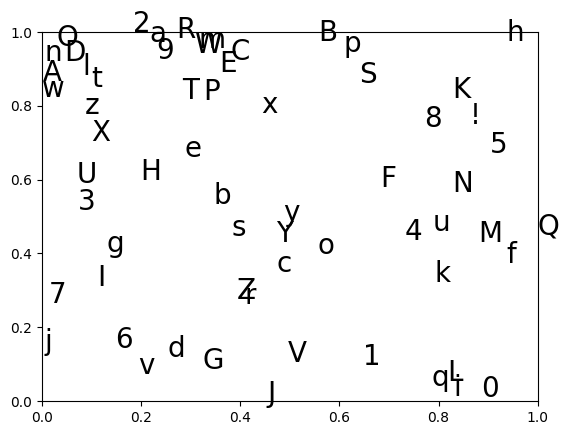

In [14]:
from matplotlib import pyplot as plt
# %matplotlib inline
def show():

    W = model.embed.weight.data.clone()
    W -= W.min(dim=0).values
    W /= W.max(dim=0).values

    for word,x in encoder.items():
        x = W[x]
        plt.text(x[0],x[1],word,fontsize=20)
    plt.show()

show()


0 tensor(12.4305, grad_fn=<NegBackward0>)
a ['a', 'm', 'n', 'u', 't']
g ['g', 'q', 'j', 'b', 'r']
1 ['1', '3', '4', '8', '0']
5 ['5', '0', '2', '8', '3']
Q ['Q', 'Z', 'I', 'U', 'Y']
H ['H', 'A', 'M', 'D', 'S']


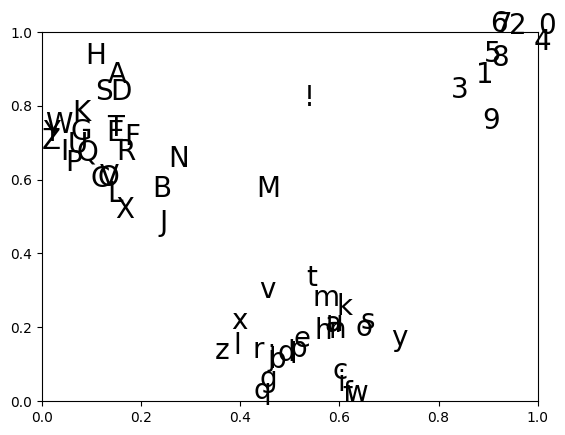

20 tensor(10.3059, grad_fn=<NegBackward0>)
a ['a', 'e', 'd', 'p', 'n']
g ['g', 'u', 'f', 'q', 'l']
1 ['4', '1', '3', '5', '7']
5 ['5', '1', '4', '3', '7']
Q ['Q', 'U', 'L', 'E', 'W']
H ['H', 'T', 'P', 'A', 'M']


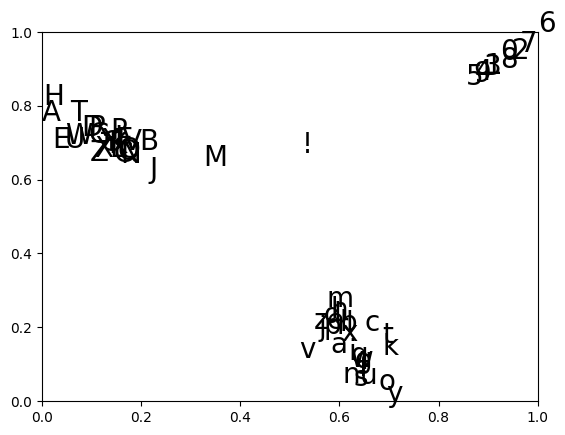

40 tensor(11.1203, grad_fn=<NegBackward0>)
a ['a', 'd', 'j', 'x', 'p']
g ['g', 'o', 't', 'u', 'y']
1 ['1', '3', '5', '7', '6']
5 ['5', '1', '3', '7', '6']
Q ['Q', 'E', 'J', 'L', 'U']
H ['H', 'A', 'R', 'D', 'T']


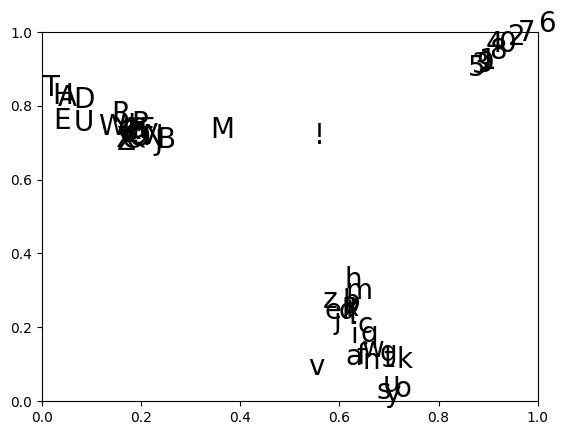

60 tensor(9.7811, grad_fn=<NegBackward0>)
a ['a', 'j', 'm', 'b', 'e']
g ['g', 'f', 'w', 'r', 'x']
1 ['1', '6', '9', '7', '8']
5 ['5', '2', '0', '3', '8']
Q ['Q', 'C', 'I', 'U', 'V']
H ['H', 'T', 'R', 'A', 'F']


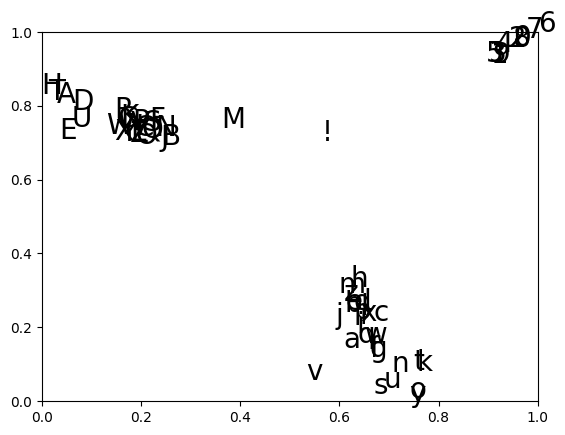

80 tensor(9.7301, grad_fn=<NegBackward0>)
a ['a', 'h', 'z', 'j', 'x']
g ['g', 's', 'f', 'n', 'l']
1 ['1', '7', '9', '0', '6']
5 ['5', '4', '2', '3', '8']
Q ['Q', 'B', 'N', 'F', 'I']
H ['H', 'A', 'T', 'R', 'F']


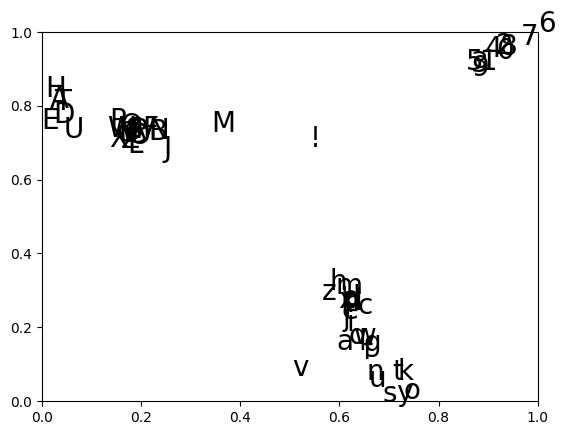

100 tensor(10.6344, grad_fn=<NegBackward0>)
a ['a', 'r', 'c', 'x', 'n']
g ['g', 's', 'l', 'n', 'w']
1 ['1', '2', '6', '8', '3']
5 ['5', '4', '8', '1', '2']
Q ['Q', 'N', 'E', 'Y', 'C']
H ['H', 'A', 'R', 'T', 'S']


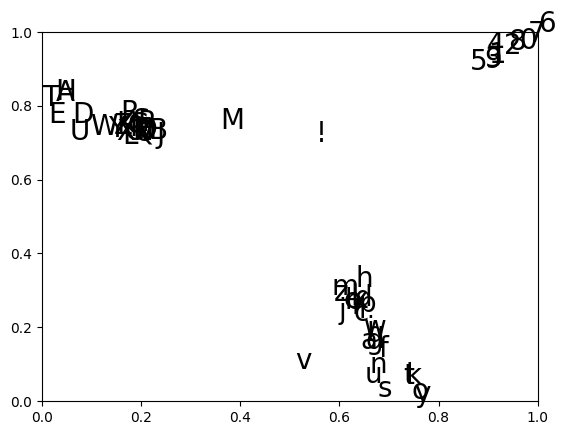

120 tensor(10.3125, grad_fn=<NegBackward0>)
a ['a', 'b', 'z', 'q', 'd']
g ['g', 'f', 'w', 't', 'i']
1 ['1', '6', '9', '7', '4']
5 ['5', '2', '8', '0', '4']
Q ['Q', 'G', 'C', 'W', 'Y']
H ['H', 'D', 'A', 'T', 'B']


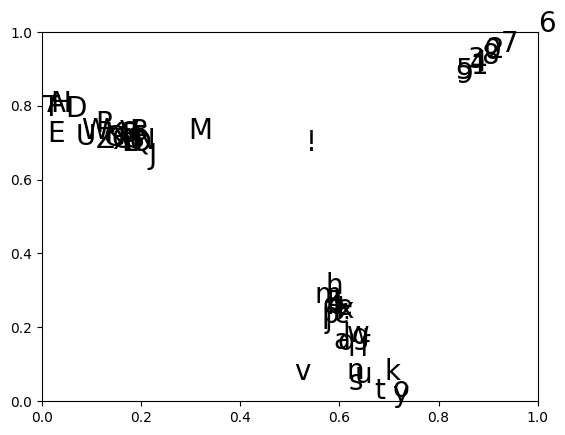

140 tensor(9.4804, grad_fn=<NegBackward0>)
a ['a', 'h', 'e', 'x', 'd']
g ['g', 'l', 'w', 'u', 's']
1 ['1', '7', '9', '6', '0']
5 ['5', '2', '3', '4', '8']
Q ['Q', 'F', 'S', 'O', 'D']
H ['H', 'T', 'A', 'R', 'P']


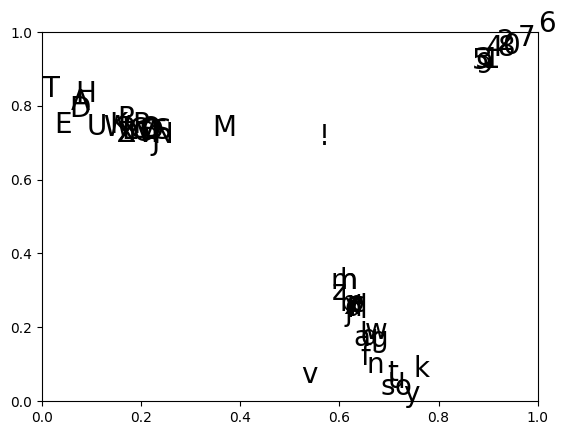

160 tensor(9.4171, grad_fn=<NegBackward0>)
a ['a', 'z', 'b', 'd', 'j']
g ['g', 'l', 'u', 'c', 'x']
1 ['1', '6', '0', '8', '5']
5 ['5', '9', '8', '7', '0']
Q ['Q', 'S', 'C', 'I', 'F']
H ['H', 'R', 'T', 'G', 'M']


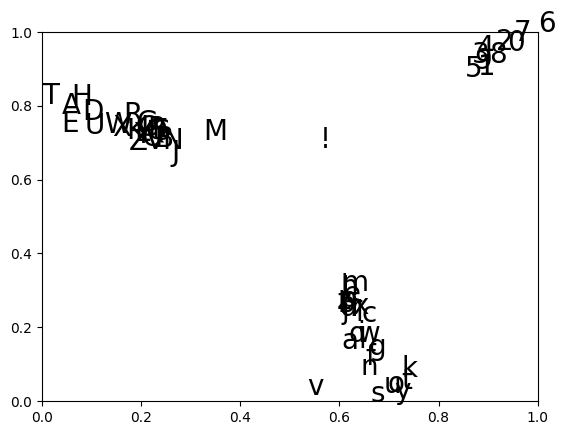

180 tensor(10.4255, grad_fn=<NegBackward0>)
a ['a', 'i', 'z', 'b', 'j']
g ['g', 'c', 'n', 'r', 'l']
1 ['1', '7', '8', '3', '0']
5 ['5', '3', '8', '2', '7']
Q ['Q', 'K', 'P', 'V', 'W']
H ['H', 'A', 'T', 'R', 'S']


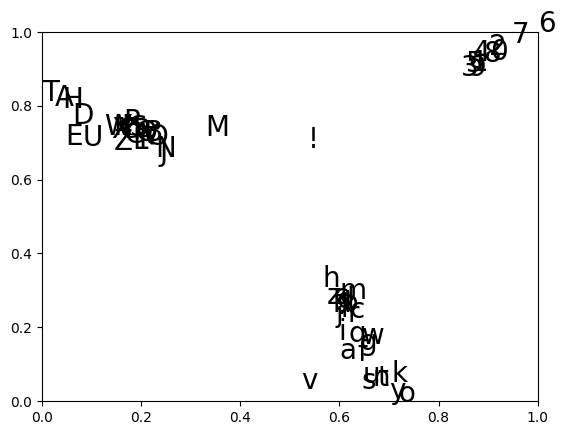

200 tensor(11.5917, grad_fn=<NegBackward0>)
a ['a', 'z', 'e', 'j', 'b']
g ['g', 'l', 'n', 'u', 'r']
1 ['1', '5', '8', '6', '0']
5 ['5', '8', '1', '6', '0']
Q ['Q', 'E', 'L', 'Z', 'J']
H ['H', 'T', 'A', 'I', 'D']


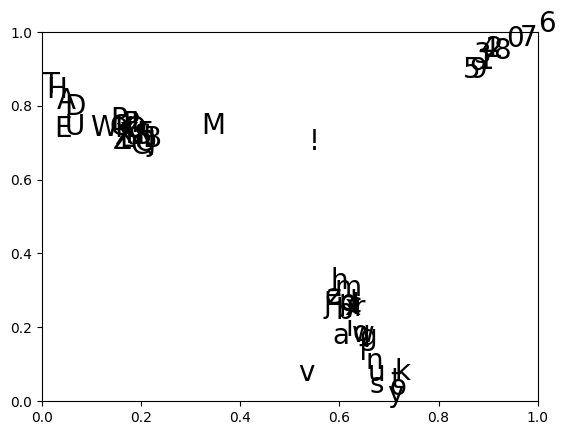

In [15]:
# import tqdm
model.train()
optimizer = torch.optim.Adam(model.parameters(),lr=2e-3)
for epoch in range(201):
    for i,(x,y,neg) in enumerate(dataloder):
        loss = model(x,y,neg)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if epoch % 20 == 0:
        print(epoch,loss)
        test(test_words=['a', 'g', '1', '5', 'Q', 'H'])
        show()